# PoseButcher Example

> _A good butcher always trims the fat_

PoseButcher is a tool for categorising and segmenting virtual hits with reference to experimental protein structures and (fragment) hits.

This notebook is demonstrates the features of PoseButcher with crystal structures from the [Enteroviral 2A protease](https://fragalysis.diamond.ac.uk/viewer/react/preview/target/A71EV2A/tas/lb18145-1).

### This example at a glance

1. Create the **butcher**:

2. **Chop** up a posed virtual hit (rdkit `Mol` with a conformer):

3. **Tag** a compound based on its pocket occupancy and clashes:

4. (Coming soon) **Trim** a parts of a compound that clash with a protein or leave the crystal

5. (Coming soon) **Explore** the expansion opportunities from a given atom in a virtual hit

6. (Coming soon) **Score** how well a virtual hit recapitulates shape and colour of the fragment bolus

## Imports

In [1]:
from posebutcher import PoseButcher
from rdkit.Chem import PandasTools

## 1. Create the butcher

### Specify the protein template

This must be a `str` or `pathlib.Path` to a reference protein structure. Non-protein atoms will automatically be ignored.

In [44]:
protein = 'test_data/2a_hits/A71EV2A-x0310_0A_bound.pdb'

### Specify the reference fragments

In [45]:
hits = 'test_data/2a_fragments.sdf'

### Define the catalytic/allosteric pockets

Defining the pockets can be tricky, I suggest you use an external tool (PyMOL/Fragalysis) to pick the correct atoms.

For now only spherical pockets are supported.

In any case, pockets should be a `dict` with `str` keys and `dict` values. Below, spherical pockets are defined at the centre of mass of several atoms with a radius defined by the average distance from CoM to the atoms or a given value:

In [46]:
pockets = {
    "P1": dict(type='sphere', atoms=['GLY 127 O', 'PRO 107 CG', 'CYS 110 SG'], radius='mean'),
    "P2": dict(type='sphere', atoms=['VAL 84 CG1', 'TYR 90 CD2', 'SER 87 CB'], radius='mean'),
    "P1'": dict(type='sphere', atoms=['GLU 88 CB', 'PRO 107 CB', 'HIS 21 CD2'], radius='mean'),
    "P2'": dict(type='sphere', atoms=['PRO 107 CB', 'LEU 22 CD1'], shift=[0, 0, 0], radius='mean'),
    "P3": dict(type='sphere', atoms=['GLY 127 O', 'GLU 85 CB'], radius=4),
    "P4": dict(type='sphere', atoms=['LEU 98 CD2'], radius=5),
    "P5": dict(type='sphere', atoms=['ASN 129 ND2', 'ASN 129 ND2', 'ILE 82 CG2'], radius=4),
    "P6": dict(type='sphere', atoms=['ILE 82 CG2'], shift=[-1,0,1], radius=4),
}

N.B. Other options for radius are: 'min' or 'max' and shift can be used to manually move the centre of the pocket.

### Create the butcher

In [48]:
butcher = PoseButcher(protein, hits, pockets)

>>> PoseButcher                        
parsing test_data/2a_hits/A71EV2A-x0310_0A_bound.pdb ... Done.
writing apo_template.pdb ...              Done.
parsing test_data/2a_fragments.sdf ...    Done.
Pocket "P1", radius=4.43, center=[9.50, 11.36, 24.20]
Pocket "P2", radius=3.58, center=[9.16, 16.79, 20.45]
Pocket "P1'", radius=4.11, center=[13.54, 14.77, 25.75]
Pocket "P2'", radius=4.12, center=[15.31, 10.98, 25.12]
Pocket "P3", radius=4.00, center=[3.52, 14.69, 22.79]
Pocket "P4", radius=5.00, center=[6.04, 11.96, 14.72]
Pocket "P5", radius=4.00, center=[-0.79, 13.10, 20.31]
Pocket "P6", radius=4.00, center=[0.88, 13.49, 14.92]
Clipping pockets...                                     
pocket-pocket intersection...                           
pocket convex hull...                                   
clipping pockets (protein)                              
Generating protein mesh...                              
pygamer.readPDB_molsurf...                              
compute_orientation...

### Render the resulting complex

This will open an Open3d viewer of the various meshes. Useful features:

* `Scene / Show Axis` Show the coordinate axes (x=red, y=blue, z=green)
* `Geometries` Toggle visibility of different meshes

In [51]:
butcher.render()

writing fragment_bolus.pdb ...            Done.
pygamer.readPDB_molsurf...                              
Could not find ResidueName 'LIG' in table. Using default radius.
compute_orientation...                                  
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default radius.
Could not find ResidueName 'LIG' in table. Using default r

## 2. Chop up a posed de novo compound

In this case we are loading an SD file containing posed molecules

In [56]:
mol_df = PandasTools.LoadSDF('test_data/2a_compounds.sdf')
mol = mol_df.iloc[45]['ROMol']
mol._Name = mol_df.iloc[45]['ID']

Now we **chop** the molecule by pocket or protein/solvent clashes

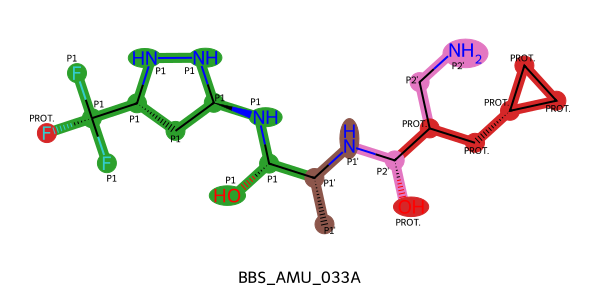

In [60]:
result = butcher.chop(mol)

the result will be a dictionary with atom indices as keys:

In [61]:
result

{0: ('GOOD', 'pocket', "P1'"),
 1: ('GOOD', 'pocket', "P1'"),
 2: ('GOOD', 'pocket', "P1'"),
 3: ('GOOD', 'pocket', "P2'"),
 4: ('BAD', 'protein clash'),
 5: ('BAD', 'protein clash'),
 6: ('GOOD', 'pocket', "P2'"),
 7: ('GOOD', 'pocket', "P2'"),
 8: ('BAD', 'protein clash'),
 9: ('BAD', 'protein clash'),
 10: ('BAD', 'protein clash'),
 11: ('BAD', 'protein clash'),
 12: ('GOOD', 'pocket', 'P1'),
 13: ('GOOD', 'pocket', 'P1'),
 14: ('GOOD', 'pocket', 'P1'),
 15: ('GOOD', 'pocket', 'P1'),
 16: ('GOOD', 'pocket', 'P1'),
 17: ('GOOD', 'pocket', 'P1'),
 18: ('GOOD', 'pocket', 'P1'),
 19: ('BAD', 'protein clash'),
 20: ('GOOD', 'pocket', 'P1'),
 21: ('GOOD', 'pocket', 'P1'),
 22: ('GOOD', 'pocket', 'P1'),
 23: ('GOOD', 'pocket', 'P1')}

The compound can also be visualised in 3d or not at all with the option `draw=False`:

In [65]:
butcher.chop(mol, draw='3d');

If your ligand is an elaboration or expansion of a known **base** (parent) compound you can consider only the novel material:

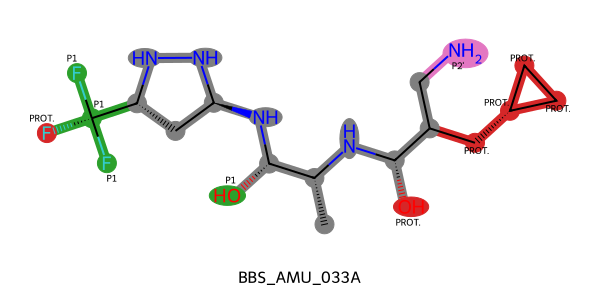

{0: ('BASE', 'atom in base'),
 1: ('BASE', 'atom in base'),
 2: ('BASE', 'atom in base'),
 3: ('BASE', 'atom in base'),
 4: ('BAD', 'protein clash'),
 5: ('BASE', 'atom in base'),
 6: ('BASE', 'atom in base'),
 7: ('GOOD', 'pocket', "P2'"),
 8: ('BAD', 'protein clash'),
 9: ('BAD', 'protein clash'),
 10: ('BAD', 'protein clash'),
 11: ('BAD', 'protein clash'),
 12: ('BASE', 'atom in base'),
 13: ('GOOD', 'pocket', 'P1'),
 14: ('BASE', 'atom in base'),
 15: ('BASE', 'atom in base'),
 16: ('BASE', 'atom in base'),
 17: ('BASE', 'atom in base'),
 18: ('GOOD', 'pocket', 'P1'),
 19: ('BAD', 'protein clash'),
 20: ('GOOD', 'pocket', 'P1'),
 21: ('GOOD', 'pocket', 'P1'),
 22: ('BASE', 'atom in base'),
 23: ('BASE', 'atom in base')}

In [70]:
butcher.chop(mol, base='C[C@H](NC(=O)/C(C#N))C(=O)Nc1cc[nH]n1')

## 3. Get a compound's tags

If you want to use pockets to tag a compound but care which atoms use `butcher.tag`:

In [66]:
butcher.tag(mol)

{'P1', "P1'", "P2'", 'protein clash'}

In [71]:
butcher.tag(mol, pockets_only=True)

{'P1', "P1'", "P2'"}

The familiar `draw` options of `'2d'` and `'3d'` are still available, as is the `base` argument.